# Transforming Vertical Coordinates

A common need in the analysis of ocean and atmospheric data is to transform the vertical coordinate from its original coordinate (e.g. depth) to a new coordinate (e.g. density).
Xgcm supports this sort of one-dimensional coordinate transform on a single Axis of an `xgcm.Grid` object using the `transform` method.
Two algorithms are implemented:

- _Linear interpolation:_ Linear interpolation is designed to interpolate intensive quantities (e.g. temperature) from one coordinate to another. This method is suitable when the target coordinate is monotonically increasing or decreasing and the data variable is intensive. For example, you want to visualize oxygen on density surfaces from a z-coordinate ocean model.
    - _Logarithmic interpolation:_ Logarithmic interpolation (which is linear interpolation done after applying a logarithm to the target coordinate) is also available. This method is suitable when variation of the intensive quantity is best related to the logarithm of the target coordinate, rather than the target coordinate itself. For example, you want to analyze data from a sigma-coordinate atmospheric model on isobaric (constant pressure) surfaces.
- _Conservative remapping:_ This algorithm is designed to conserve extensive quantities (e.g. transport, heat content). It requires knowledge of cell bounds in both the source and target coordinate. It also handles non-monotonic target coordinates.

On this page, we explain how to use these coordinate transformation capabilities.

In [1]:
from xgcm import Grid
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## 1D Toy Data Example

First we will create a simple, one-dimensional dataset to illustrate how the `transform` function works.
This dataset contains

- a coordinate called `z`, representing the original depth coordinate

- a data variable called `theta`, a function of `z`, which we want as our new vertical coordinate

- a data variable called `phi`, also a function of `z`, which represents the data we want to transform into this new coordinate space

In an oceanic context `theta` might be density and `phi` might be oxygen.
In an atmospheric context, `theta` might be potential temperature and `phi` might be potential vorticity.

In [2]:
z = np.arange(2, 12)
theta = xr.DataArray(np.log(z), dims=['z'], coords={'z': z})
phi = xr.DataArray(np.flip(np.log(z)*0.5+ np.random.rand(len(z))), dims=['z'], coords={'z':z})
ds = xr.Dataset({'phi': phi, 'theta': theta})
ds

<xarray.Dataset> Size: 240B
Dimensions:  (z: 10)
Coordinates:
  * z        (z) int64 80B 2 3 4 5 6 7 8 9 10 11
Data variables:
    phi      (z) float64 80B 1.305 2.08 1.866 1.748 ... 1.222 1.076 1.103 0.5949
    theta    (z) float64 80B 0.6931 1.099 1.386 1.609 ... 2.197 2.303 2.398

Let's plot this data. Note that, for a simple 1D profile, we can easily visualize `phi` in `theta` space by simply plotting `phi` vs. `theta`. This is essentially a form of linear interpolation, performed automatically by matplotlib when it draws lines between the discrete points of our data.

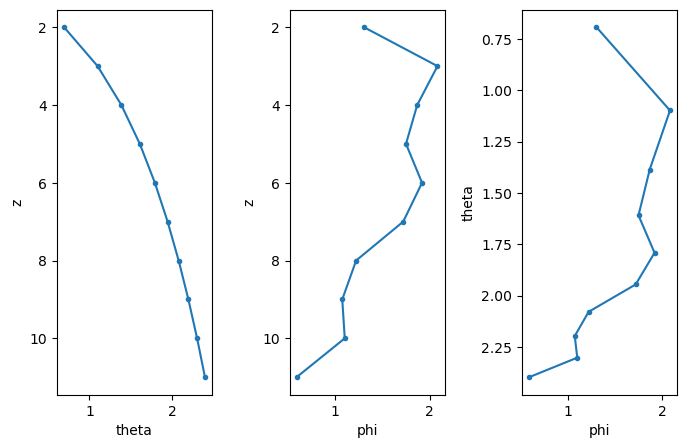

In [3]:
def plot_profile():
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[8,5])
    ds.theta.plot(ax=ax1, y='z', marker='.', yincrease=False)
    ds.phi.plot(ax=ax2, y='z', marker='.', yincrease=False)
    ds.swap_dims({'z': 'theta'}).phi.plot(ax=ax3, y='theta', marker='.', yincrease=False)
    fig.subplots_adjust(wspace=0.5)
    return ax3

plot_profile();

### Linear transformation

Ok now lets transform `phi` to `theta` coordinates using linear interpolation.
A key part of this is to define specific `theta` levels onto which we want to interpolate the data.

In [4]:
# First create an xgcm grid object
grid = Grid(ds, coords={'Z': {'center':'z'}}, periodic=False, autoparse_metadata=False)

# define the target values in density, linearly spaced
theta_target = np.linspace(0, 3, 20)

# and transform
phi_transformed = grid.transform(ds.phi, 'Z', theta_target, target_data=ds.theta)
phi_transformed

<xarray.DataArray 'phi' (theta: 20)> Size: 160B
array([       nan,        nan,        nan,        nan,        nan,
       1.48932767, 1.7909242 , 2.07487921, 1.95765793, 1.84783612,
       1.76422809, 1.86621671, 1.78446418, 1.32197131, 1.07966374,
       0.75194647,        nan,        nan,        nan,        nan])
Coordinates:
  * theta    (theta) float64 160B 0.0 0.1579 0.3158 0.4737 ... 2.684 2.842 3.0

Now let's see what the result looks like.

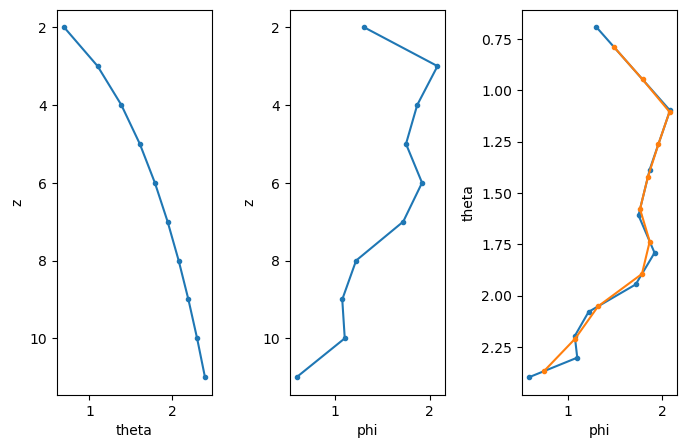

In [5]:
ax = plot_profile()
phi_transformed.plot(ax=ax, y='theta', marker='.')

Not too bad. We can increase the number of interpolation levels to capture more of the small scale structure.

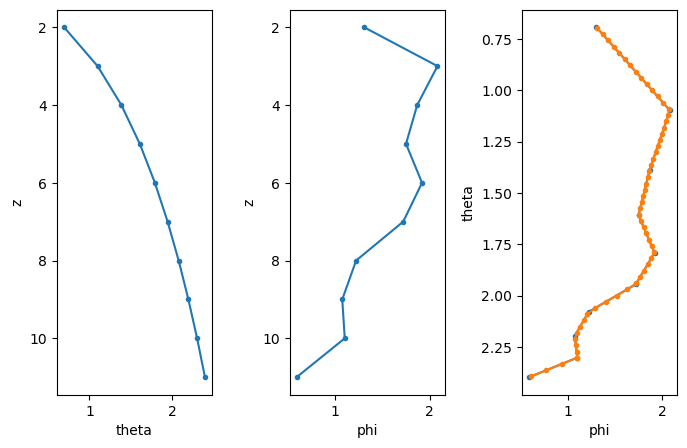

In [6]:
target_theta = np.linspace(0,3, 100)
phi_transformed = grid.transform(ds.phi, 'Z', target_theta, target_data=ds.theta)
ax = plot_profile()
phi_transformed.plot(ax=ax, y='theta', marker='.')

Note that by default, values of `theta_target` which lie outside the range of `theta` have been masked (set to `NaN`).
To disable this behavior, you can pass `mask_edges=False`; values outside the range of `theta` will be filled with the nearest valid value.

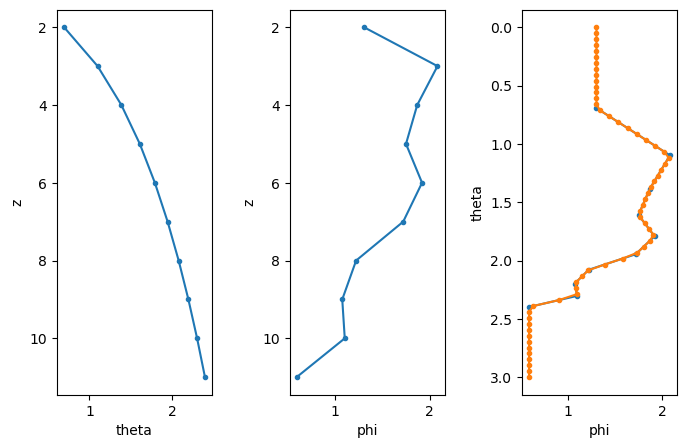

In [7]:
target_theta = np.linspace(0,3, 60)
phi_transformed = grid.transform(ds.phi, 'Z', target_theta, target_data=ds.theta, mask_edges=False)
ax = plot_profile()
phi_transformed.plot(ax=ax, y='theta', marker='.')

### Conservative transformation

Conservative transformation is designed to preseve the total sum of `phi` over the `Z` axis.
It presumes that `phi` is an _extensive quantity_, i.e. a quantity that is already volume weighted, with respect to the Z axis: for example, units of `Kelvins * meters` for heat content, rather than just `Kelvins`.
The conservative method requires more input data at the moment.
You have to not only specify the coordinates of the cell centers, but also the cell faces (or bounds/boundaries). In xgcm we achieve this by defining the bounding coordinates as the `outer` axis position.
The target `theta` values are likewise intepreted as cell boundaries in `theta`-space.
In this way, conservative transformation is similar to calculating a histogram.

In [8]:
# define the cell bounds in depth
zc = np.arange(1,12)+0.5

# add them to the existing dataset
ds = ds.assign_coords({'zc': zc})
ds

<xarray.Dataset> Size: 328B
Dimensions:  (z: 10, zc: 11)
Coordinates:
  * z        (z) int64 80B 2 3 4 5 6 7 8 9 10 11
  * zc       (zc) float64 88B 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
Data variables:
    phi      (z) float64 80B 1.305 2.08 1.866 1.748 ... 1.222 1.076 1.103 0.5949
    theta    (z) float64 80B 0.6931 1.099 1.386 1.609 ... 2.197 2.303 2.398

In [9]:
# Recreate the grid object with a staggered `center`/`outer` coordinate layout
grid = Grid(ds, coords={'Z':{'center':'z', 'outer':'zc'}}, periodic=False, autoparse_metadata=False)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary='fill'):
  * center   z --> outer
  * outer    zc --> center

Currently the `target_data`(`theta` in this case) has to be located on the `outer` coordinate for the conservative method (compared to the `center` for the linear method).

We can easily interpolate `theta` on the outer coordinate with the grid object.

In [10]:
ds['theta_outer'] = grid.interp(ds.theta, 'Z', boundary='fill')
ds['theta_outer']

<xarray.DataArray 'theta_outer' (zc: 11)> Size: 88B
array([0.34657359, 0.89587973, 1.24245332, 1.49786614, 1.70059869,
       1.86883481, 2.01267585, 2.13833306, 2.24990484, 2.35024018,
       1.19894764])
Coordinates:
  * zc       (zc) float64 88B 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5

Now lets transform the data using the conservative method. Note that the target values will now be interpreted as cell bounds and not cell centers as before.

In [11]:
# define the target values in density
theta_target = np.linspace(0,3, 20)

# and transform
phi_transformed_cons = grid.transform(ds.phi,
                                      'Z',
                                      theta_target,
                                      method='conservative',
                                      target_data=ds.theta_outer)
phi_transformed_cons

<xarray.DataArray 'phi' (theta_outer: 19)> Size: 152B
array([0.        , 0.        , 0.30205693, 0.37521019, 0.37521019,
       0.56184389, 0.94753939, 1.00775299, 1.23529019, 1.3419802 ,
       1.54355447, 1.89517934, 1.87933616, 1.61171464, 1.55477669,
       0.        , 0.        , 0.        , 0.        ])
Coordinates:
  * theta_outer  (theta_outer) float64 152B 0.07895 0.2368 ... 2.763 2.921

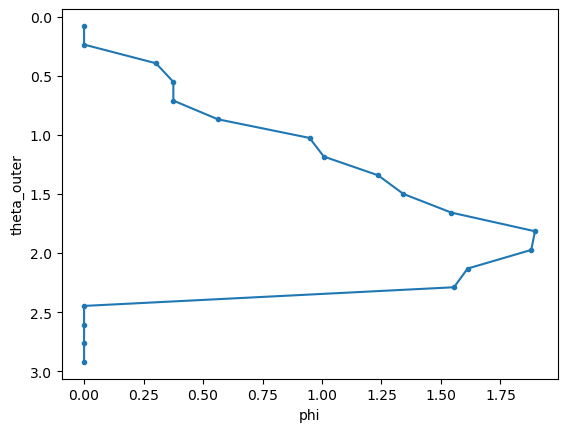

In [12]:
phi_transformed_cons.plot(y='theta_outer', marker='.', yincrease=False)

There is no point in comparing `phi_transformed_cons` directly to `phi` or the results of linear interoplation, since here we have reinterpreted `phi` as an extensive quantity.
However, we can verify that the sum of the two quantities over the Z axis is exactly the same.

In [13]:
ds.phi.sum().values

array(14.63144527)

In [14]:
phi_transformed_cons.sum().values

array(14.63144527)

### Logarithmic Interpolation

Since logarithmic interpolation is most often used when tranforming to pressure (isobaric) coordinates, let's use a new set of example data:

In [15]:
ds = xr.Dataset(
    {
        'temperature': ('sigma', [271.75452, 272.79956, 274.8517, 279.22043, 296.48782]),
        'pressure': ('sigma', [100180.625, 96250.0, 87369.14, 72186.66, 53718.586]),
    },
    {
        'sigma': [0.9969, 0.9558, 0.8631, 0.7046, 0.5117]
    }
)

Let's now transform `temperature` to `pressure` coordinates. As before, a key part of this is to define specific `pressure` levels onto which we want to interpolate the data.

In [16]:
# Create an xgcm grid object
grid = Grid(ds, coords={'Z': {'center':'sigma'}}, periodic=False, autoparse_metadata=False)

# Define isobaric levels of interest (a few standard levels)
isobaric_target_levels = np.array([1.0e5, 8.5e4, 7.0e4])

# and transform
temperature_isobaric = grid.transform(ds.temperature, 'Z', isobaric_target_levels, target_data=ds.pressure, method='log')
temperature_isobaric

<xarray.DataArray 'temperature' (pressure: 3)> Size: 24B
array([271.80163709, 275.48086957, 281.01789905])
Coordinates:
  * pressure  (pressure) float64 24B 1e+05 8.5e+04 7e+04

And finally, let's see what the result looks like.

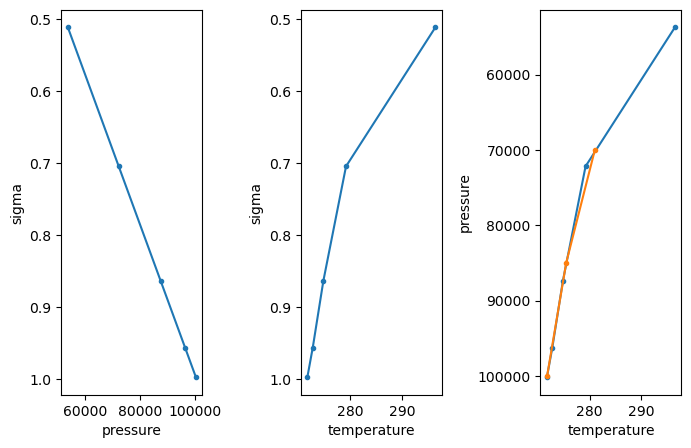

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[8,5])
ds.pressure.plot(ax=ax1, y='sigma', marker='.', yincrease=False)
ds.temperature.plot(ax=ax2, y='sigma', marker='.', yincrease=False)
ds.swap_dims({'sigma': 'pressure'}).temperature.plot(ax=ax3, y='pressure', marker='.', yincrease=False)
temperature_isobaric.plot(ax=ax3, y='pressure', marker='.')

fig.subplots_adjust(wspace=0.7)

plt.show();

## Realistic Data Example


To illustrate these features in a more realistic example, we use data from the CNRM CMIP6 model.
These data are available from the [Pangeo Cloud Data Library](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#loading-an-esm-collection).
We can see that this is a full, global, 4D ocean dataset.

In [20]:
import intake
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(
    source_id = 'CNRM-ESM2-1',
    member_id = 'r1i1p1f2',
    experiment_id = 'historical',
    variable_id= ['thetao','so','vo','areacello'],
    grid_label = 'gn'
)
ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True, 'use_cftime':True}, aggregate=False)




--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [21]:
thetao = ddict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/thetao/gn/v20181206/.20181206']
so = ddict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.so.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/so/gn/v20181206/.20181206']
vo = ddict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.vo.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/vo/gn/v20181206/.20181206']
areacello = ddict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Ofx.areacello.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Ofx/areacello/gn/v20181206/.20181206'].areacello

vo = vo.rename({'y':'y_c', 'lon':'lon_v', 'lat':'lat_v', 'bounds_lon':'bounds_lon_v', 'bounds_lat':'bounds_lat_v'})

ds = xr.merge([thetao,so,vo], compat='override')
ds = ds.assign_coords(areacello=areacello.fillna(0))
ds

<xarray.Dataset> Size: 190GB
Dimensions:         (y: 294, x: 362, nvertex: 4, lev: 75, axis_nbounds: 2,
                     member_id: 1, dcpp_init_year: 1, time: 1980, y_c: 294)
Coordinates: (12/15)
    bounds_lat      (y, x, nvertex) float64 3MB dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon      (y, x, nvertex) float64 3MB dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat             (y, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev             (lev) float64 600B 0.5058 1.556 ... 5.698e+03 5.902e+03
    lev_bounds      (lev, axis_nbounds) float64 1kB dask.array<chunksize=(75, 2), meta=np.ndarray>
    lon             (y, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    ...              ...
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    bounds_lat_v    (y_c, x, nvertex) float64 3MB dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon_v    (y_c, x, nvertex) float64 3MB dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    areacello       (member_id, dcpp_init_year, y, x) float32 426kB dask.array<chunksize=(1, 1, 294, 362), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds, y_c
Data variables:
    thetao          (member_id, dcpp_init_year, time, lev, y, x) float32 63GB dask.array<chunksize=(1, 1, 4, 75, 294, 362), meta=np.ndarray>
    so              (member_id, dcpp_init_year, time, lev, y, x) float32 63GB dask.array<chunksize=(1, 1, 5, 75, 294, 362), meta=np.ndarray>
    vo              (member_id, dcpp_init_year, time, lev, y_c, x) float32 63GB dask.array<chunksize=(1, 1, 3, 75, 294, 362), meta=np.ndarray>
Attributes: (12/68)
    CMIP6_CV_version:                 cv=6.2.3.0-7-g2019642
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            CNRM-ESM2-1_historical_r1i1p1f2
    activity_id:                      CMIP
    arpege_minor_version:             6.3.2
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     thetao
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM...
    intake_esm_attrs:version:         20181206
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CNRM-CERFACS.CNRM-ESM2-1.historica...

The grid is missing an `outer` coordinate for the Z axis, so we will construct one.
This will be needed for conservative interpolation.

In [22]:
import cf_xarray
level_outer_data = cf_xarray.bounds_to_vertices(ds.lev_bounds, 'axis_nbounds').load().data

ds = ds.assign_coords({'level_outer': level_outer_data})

### Linear Interpolation

#### Depth to Depth
To illustrate linear interpolation, we will first interpolate salinity onto a uniformly spaced vertical grid. 

In [23]:
grid = Grid(
    ds, 
    coords={'Z': {'center': 'lev'},},
    periodic=False,
    autoparse_metadata=False
)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary='fill'):
  * center   lev

In [24]:
target_depth_levels = np.arange(0,500,50)
salt_on_depth = grid.transform(ds.so, 'Z', target_depth_levels, target_data=None, method='linear')
salt_on_depth

<xarray.DataArray 'so' (member_id: 1, dcpp_init_year: 1, time: 1980, y: 294,
                        x: 362, lev: 10)> Size: 8GB
dask.array<transpose, shape=(1, 1, 1980, 294, 362, 10), dtype=float32, chunksize=(1, 1, 5, 294, 362, 10), chunktype=numpy.ndarray>
Coordinates:
    lat             (y, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon             (y, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
  * member_id       (member_id) object 8B 'r1i1p1f2'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    areacello       (member_id, dcpp_init_year, y, x) float32 426kB dask.array<chunksize=(1, 1, 294, 362), meta=np.ndarray>
  * lev             (lev) int64 80B 0 50 100 150 200 250 300 350 400 450
Dimensions without coordinates: y, x

Note that the computation is lazy. (No data has been downloaded or computed yet.)
We can trigger computation by plotting something.

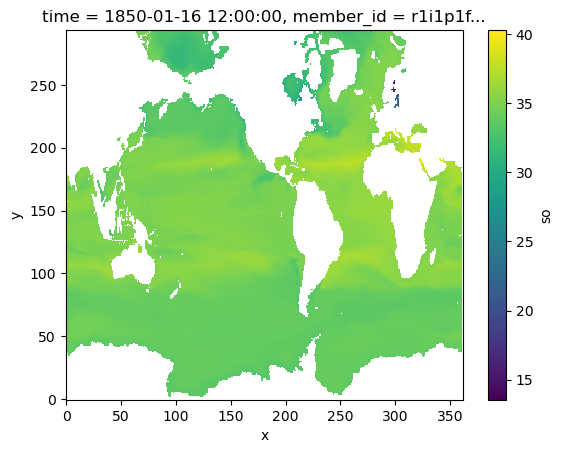

/global/homes/n/nloose/.conda/envs/test_env_xgcm/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


In [25]:
salt_on_depth.isel(time=0).sel(lev=50).plot()

#### Depth to Potential Temperature
We can also interpolate salinity onto temperature surface through linear interpolation.

In [26]:
target_theta_levels = np.arange(-2, 36)
salt_on_theta = grid.transform(ds.so, 'Z', target_theta_levels, target_data=ds.thetao, method='linear')
salt_on_theta

<xarray.DataArray 'so' (member_id: 1, dcpp_init_year: 1, time: 1980, y: 294,
                        x: 362, thetao: 38)> Size: 32GB
dask.array<transpose, shape=(1, 1, 1980, 294, 362, 38), dtype=float32, chunksize=(1, 1, 4, 294, 362, 38), chunktype=numpy.ndarray>
Coordinates:
    lat             (y, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon             (y, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
  * member_id       (member_id) object 8B 'r1i1p1f2'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    areacello       (member_id, dcpp_init_year, y, x) float32 426kB dask.array<chunksize=(1, 1, 294, 362), meta=np.ndarray>
  * thetao          (thetao) int64 304B -2 -1 0 1 2 3 4 ... 29 30 31 32 33 34 35
Dimensions without coordinates: y, x

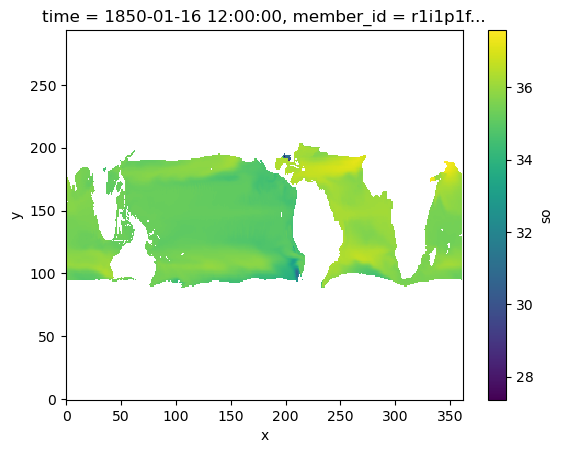

/global/homes/n/nloose/.conda/envs/test_env_xgcm/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


In [27]:
salt_on_theta.isel(time=0).sel(thetao=20).plot()

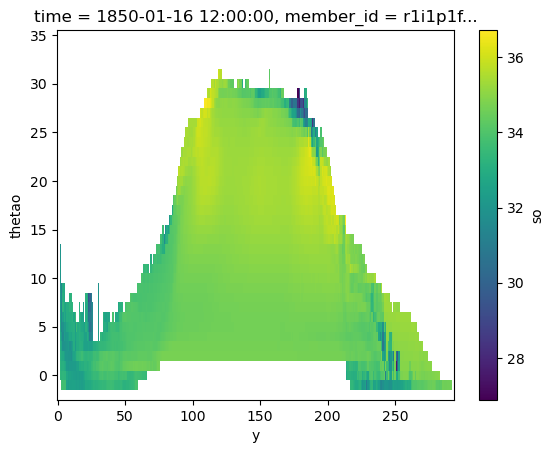

In [28]:
salt_on_theta.isel(time=0).mean(dim='x').plot(x='y')

### Conservative Interpolation

To do conservative interpolation, we will attempt to calculate the meridional overturning in temperature space.
Note that this is not a perfectly precise calculation.
However, it's sufficient to illustrate the basic principles of the calculation.

Create another grid object for conservative interpolation.

In [30]:
ds

<xarray.Dataset> Size: 190GB
Dimensions:         (y: 294, x: 362, nvertex: 4, lev: 75, axis_nbounds: 2,
                     member_id: 1, dcpp_init_year: 1, time: 1980, y_c: 294,
                     level_outer: 76)
Coordinates: (12/16)
    bounds_lat      (y, x, nvertex) float64 3MB dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon      (y, x, nvertex) float64 3MB dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat             (y, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev             (lev) float64 600B 0.5058 1.556 ... 5.698e+03 5.902e+03
    lev_bounds      (lev, axis_nbounds) float64 1kB dask.array<chunksize=(75, 2), meta=np.ndarray>
    lon             (y, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    ...              ...
    bounds_lat_v    (y_c, x, nvertex) float64 3MB dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon_v    (y_c, x, nvertex) float64 3MB dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    areacello       (member_id, dcpp_init_year, y, x) float32 426kB dask.array<chunksize=(1, 1, 294, 362), meta=np.ndarray>
  * level_outer     (level_outer) float64 608B 0.0 1.024 ... 5.8e+03 6.004e+03
Dimensions without coordinates: y, x, nvertex, axis_nbounds, y_c
Data variables:
    thetao          (member_id, dcpp_init_year, time, lev, y, x) float32 63GB dask.array<chunksize=(1, 1, 4, 75, 294, 362), meta=np.ndarray>
    so              (member_id, dcpp_init_year, time, lev, y, x) float32 63GB dask.array<chunksize=(1, 1, 5, 75, 294, 362), meta=np.ndarray>
    vo              (member_id, dcpp_init_year, time, lev, y_c, x) float32 63GB dask.array<chunksize=(1, 1, 3, 75, 294, 362), meta=np.ndarray>
Attributes: (12/68)
    CMIP6_CV_version:                 cv=6.2.3.0-7-g2019642
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            CNRM-ESM2-1_historical_r1i1p1f2
    activity_id:                      CMIP
    arpege_minor_version:             6.3.2
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     thetao
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM...
    intake_esm_attrs:version:         20181206
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CNRM-CERFACS.CNRM-ESM2-1.historica...

In [40]:
grid = Grid(
    ds, 
    coords={
        'Z': {'center': 'lev', 'outer': 'level_outer'},
        'X': {'center': 'x'},
        'Y': {'center': 'y', 'right': 'y_c'}
    },
    periodic=False,
    autoparse_metadata=False
)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary='fill'):
  * center   lev --> outer
  * outer    level_outer --> center
X Axis (not periodic, boundary='fill'):
  * center   x
Y Axis (not periodic, boundary='fill'):
  * center   y --> right
  * right    y_c --> center

To use conservative interpolation, we have to go from an intensive quantity (velocity) to an extensive one (velocity times cell thickness).
We fill any missing values with 0, since they don't contribute to the transport.

In [41]:
thickness = grid.diff(ds.level_outer, 'Z')
v_transport =  ds.vo * thickness
v_transport = v_transport.fillna(0.).rename('v_transport')
v_transport

<xarray.DataArray 'v_transport' (member_id: 1, dcpp_init_year: 1, time: 1980,
                                 lev: 75, y_c: 294, x: 362)> Size: 126GB
dask.array<where, shape=(1, 1, 1980, 75, 294, 362), dtype=float64, chunksize=(1, 1, 3, 75, 294, 362), chunktype=numpy.ndarray>
Coordinates:
  * lev             (lev) float64 600B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
  * member_id       (member_id) object 8B 'r1i1p1f2'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    lat_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
Dimensions without coordinates: y_c, x

We also need to interpolate `theta` or thetao, our target data for interpolation, to the same horizontal position as `v_transport`. This means moving from cell center to cell corner.
This step introduces some considerable errors, particularly near the boundaries of bathymetry.
(Xgcm currently has no special treatment for internal boundary conditions--see issue [222](https://github.com/xgcm/xgcm/issues/240).)

In [42]:
ds['theta'] = grid.interp(ds.thetao, ['Y'], boundary='extend')
ds.theta

<xarray.DataArray 'theta' (member_id: 1, dcpp_init_year: 1, time: 1980,
                           lev: 75, y_c: 294, x: 362)> Size: 63GB
dask.array<transpose, shape=(1, 1, 1980, 75, 294, 362), dtype=float32, chunksize=(1, 1, 4, 75, 294, 362), chunktype=numpy.ndarray>
Coordinates:
  * lev             (lev) float64 600B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
  * member_id       (member_id) object 8B 'r1i1p1f2'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    lat_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
Dimensions without coordinates: y_c, x

We can transform `v_transport` to temperature space (`target_theta_levels`).

In [43]:
v_transport_theta = grid.transform(v_transport, 'Z', target_theta_levels,
                                   target_data=ds.theta, method='conservative')
v_transport_theta

/global/u2/n/nloose/xgcm/xgcm/transform.py:465: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(


<xarray.DataArray 'v_transport' (member_id: 1, dcpp_init_year: 1, time: 1980,
                                 y_c: 294, x: 362, theta: 37)> Size: 62GB
dask.array<transpose, shape=(1, 1, 1980, 294, 362, 37), dtype=float64, chunksize=(1, 1, 3, 294, 362, 37), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
  * member_id       (member_id) object 8B 'r1i1p1f2'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    lat_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon_v           (y_c, x) float64 851kB dask.array<chunksize=(294, 362), meta=np.ndarray>
  * theta           (theta) float64 296B -1.5 -0.5 0.5 1.5 ... 32.5 33.5 34.5
Dimensions without coordinates: y_c, x

Notice that this produced a warning. The `conservative` transformation method natively needs `target_data` to be provided on the cell bounds (here `level_outer`).
Since transforming onto tracer coordinates is a very common scenario, xgcm uses linear interpolation to infer the values on the `outer` axis position.

To demonstrate how to provide `target_data` on the outer grid position, we reproduce the steps xgcm executes internally:

In [44]:
theta_outer = grid.interp(ds.theta,['Z'], boundary='extend')
# the data cannot be chunked along the transformation axis
theta_outer = theta_outer.chunk({'level_outer': -1}).rename('theta')
theta_outer

<xarray.DataArray 'theta' (member_id: 1, dcpp_init_year: 1, time: 1980,
                           level_outer: 76, y_c: 294, x: 362)> Size: 64GB
dask.array<transpose, shape=(1, 1, 1980, 76, 294, 362), dtype=float32, chunksize=(1, 1, 4, 76, 294, 362), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
  * member_id       (member_id) object 8B 'r1i1p1f2'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * level_outer     (level_outer) float64 608B 0.0 1.024 ... 5.8e+03 6.004e+03
Dimensions without coordinates: y_c, x

When we apply the transformation we can see that the results in this case are equivalent:

In [45]:
v_transport_theta_manual = grid.transform(v_transport, 'Z', target_theta_levels,
                                   target_data=theta_outer, method='conservative')

# Warning: this step takes a long time to compute. We will only compare the first time value
xr.testing.assert_allclose(v_transport_theta_manual.isel(time=0), v_transport_theta.isel(time=0))


Now  we verify visually that the vertically integrated transport is conserved under this transformation.

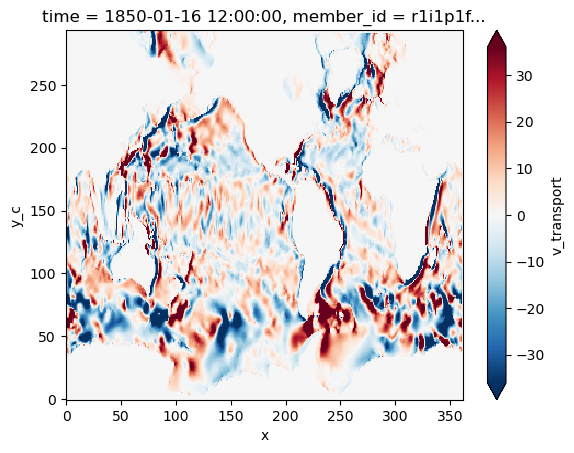

In [46]:
v_transport.isel(time=0).sum(dim='lev').plot(robust=True)

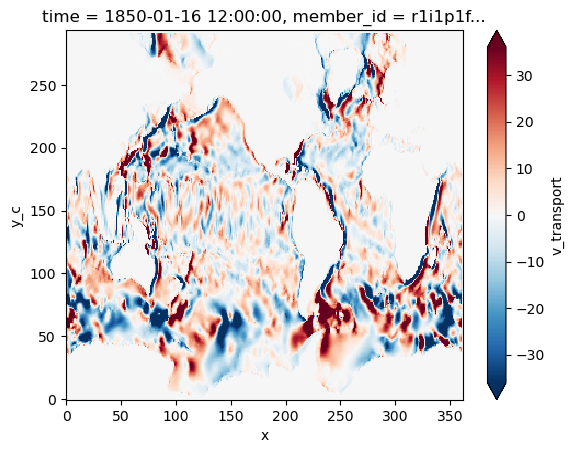

In [47]:
v_transport_theta.isel(time=0).sum(dim='theta').plot(robust=True)

Finally, we attempt to plot a crude meridional overturning streamfunction for a single timestep.

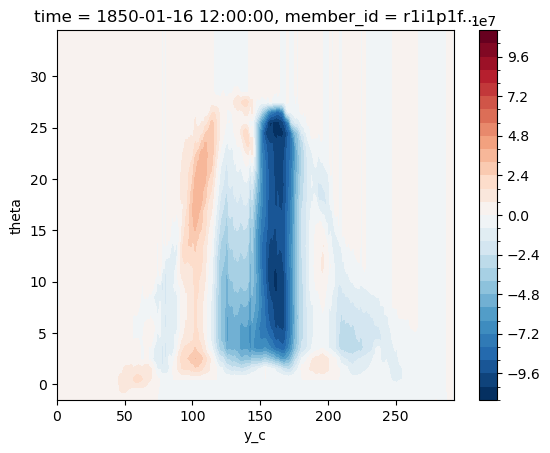

In [56]:
dx = 110e3 * np.cos(np.deg2rad(ds.lat_v))
(v_transport_theta.isel(time=0).squeeze() * dx).sum(dim='x').cumsum(dim='theta').plot.contourf(x='y_c', levels=31)

### Logarithmic Interpolation

As noted previously, logarithmic interpolation is most often used to interpolate data from atmospheric models with a non-isobaric vertical coordinate (such as sigma or hybrid sigma) to isobaric levels suitable for analysis.  And so, in place of the previous 4D ocean dataset, let's generate a synthetic 3D atmospheric dataset (loosely based on the Sanders 1971 Analytic Model) to use to explore logarithmic interpolation:

In [57]:
def generate_analytic_model(
    nx=250,
    ny=150,
    nsigma=30,
    L=3e6,
    y_max=1.8e6,
    y_scale_factor=0.333,
    alpha=0.722,
    terrain_rise=1.5e3,
    pressure_variability=1e3,
    pressure_sea_level_mean=1e5,
    pressure_top=5e3,
    scale_height=8e3,
    temperature_variability=5,
    temperature_mean_surface=300,
    temperature_mean_tropopause=228.5,
    a=1.12e-5,
    b=2.3e-3,
    k=20
):
    """Generate sythetic data for an atmospheric trough over a Gaussian terrain.
    
    Parameters
    ----------
    nx : int
        Count of grid points in x direction
    ny : int
        Count of grid points in y direction
    nsigma : int
        Count of vertical sigma coordinate levels
    L : float
        Zonal wavelength of trough [meters]
    y_max : float
        Meridional extent of domain [meters]
    alpha : float
        Vertical control parameter for tropopause location [dimensionless]
    terrain_rise : float
        Max height of the terrain [meters]
    pressure_variability : float
        Wave amplitude of sea-level pressure field [Pa]
    pressure_sea_level_mean : float
        Domain average of sea-level pressure field [Pa]
    pressure_top : float
        Uniform pressure at top of domain [Pa]
    scale_height : float
        Control parameter for conversion of sea-level pressure to surface pressure [meters]
    temperature_variability : float
        Wave amplitude of temperature perturbation field [K]
    temperature_mean_surface : float
        Horizontal mean of temperature at ground level [K]
    temperature_mean_tropopause : float
        Horizontal mean of temperature at model top [K]
    a : float
        Meridional control parameter for temperature field shape [K / m]
    b : float
        Meridional control parameter for temperature field shape [Pa / m]
    k : float
        Vertical control parameter for mean temperature profile sharpness in vertical
    
    """
    # Constants
    R = 287.05
    g = 9.81

    # Define coordinates (and broadcasted versions)
    x = np.linspace(-L / 2, L / 2, nx)
    y = np.linspace(0, y_max, ny)
    sigma = np.linspace(1, 0, nsigma)

    x_2d, y_2d = np.meshgrid(x, y)
    x_3d, y_3d, sigma_3d = np.meshgrid(x, y, sigma)
    
    # Sea-level pressure (2D) as a trough shape
    pressure_sea_level = (
        pressure_sea_level_mean
        - b * y_2d * y_scale_factor
        - pressure_variability * np.cos(2 * np.pi / L * x_2d) * np.cos(2 * np.pi / L * y_2d * y_scale_factor)
    )
    
    # Terrain height as an offset Gaussian shape (uniform in meridional direction)
    geopotential_height_surface = np.exp(-((x_2d + L / 3) / (L / 3))**2) * terrain_rise
    
    # Surface pressure (2D) from sea-level pressure and terrain height
    pressure_surface = pressure_sea_level * np.exp(
        -geopotential_height_surface / scale_height
    )
    
    # Pressure (3D) from definition of sigma coordinate
    pressure = sigma_3d * (pressure_surface - pressure_top)[..., None] + pressure_top
    
    # Trough component of temperature
    temperature_pertubation = (
        -(1 + alpha * np.log(pressure_sea_level_mean / pressure))
        * (
            a * y_3d * y_scale_factor
            + temperature_variability * np.cos(2 * np.pi / L * x_3d) * np.cos(2 * np.pi / L * y_3d * y_scale_factor)
        )
    )
    
    # Vertical component of temperature
    temperature_mean = (
        temperature_mean_tropopause
        + (
            np.log(1 + np.exp(k * (sigma + alpha - 1)))
            / np.log(1 + np.exp(k * alpha))
        ) * (temperature_mean_surface - temperature_mean_tropopause)
    )
    
    # Combine and calcuate temperature and geopotential 3D
    temperature = temperature_mean[None, None] + temperature_pertubation
    geopotential = g * geopotential_height_surface[..., None] - np.concatenate(
        (
            np.zeros_like(x_2d)[..., None],
            np.cumsum(
                (
                    R
                    * (temperature[..., :-1] + temperature[..., 1:])
                    / (sigma_3d[..., :-1] + sigma_3d[..., 1:])
                    * np.diff(sigma_3d, axis=-1)
                ),
                axis=-1
            )
        ),
        axis=-1
    )
    
    # Return dataset!
    return xr.Dataset(
        {
            'temperature': (('y', 'x', 'sigma'), temperature),
            'geopotential': (('y', 'x', 'sigma'), geopotential),
            'pressure': (('y', 'x', 'sigma'), pressure),
        },
        {
            'y': y,
            'x': x,
            'sigma': sigma
        }
    ), {
        'p_init': pressure_sea_level,
        't_init': temperature_pertubation[..., 0]
    }

ds, stuff = generate_analytic_model()

ds

<xarray.Dataset> Size: 27MB
Dimensions:       (y: 150, x: 250, sigma: 30)
Coordinates:
  * y             (y) float64 1kB 0.0 1.208e+04 2.416e+04 ... 1.788e+06 1.8e+06
  * x             (x) float64 2kB -1.5e+06 -1.488e+06 ... 1.488e+06 1.5e+06
  * sigma         (sigma) float64 240B 1.0 0.9655 0.931 ... 0.06897 0.03448 0.0
Data variables:
    temperature   (y, x, sigma) float64 9MB 305.5 302.2 298.9 ... 214.1 212.2
    geopotential  (y, x, sigma) float64 9MB 1.146e+04 1.452e+04 ... 3.418e+05
    pressure      (y, x, sigma) float64 9MB 8.728e+04 8.444e+04 ... 5e+03

This synthetic model gives a low-pressure trough centered in the domain, with a sloping terrain in the zonal direction. Here is what that terrain (surface geopotential height) looks like:

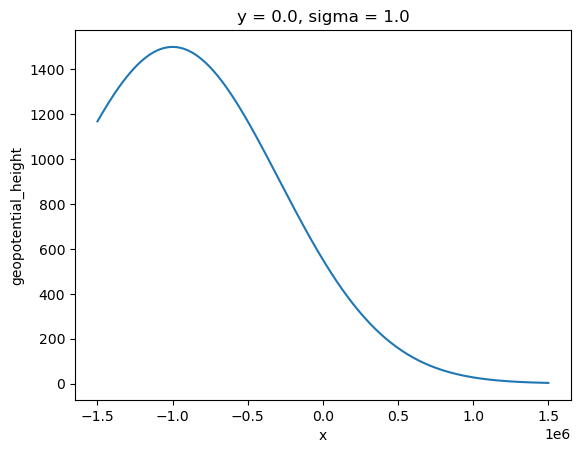

In [58]:
(ds['geopotential'] / 9.81).rename('geopotential_height').sel(sigma=1, y=0).plot()

If we were to inspect a given vertical level of these data, it would be difficult to interpret due to the terrain-following nature of the sigma coordinate:

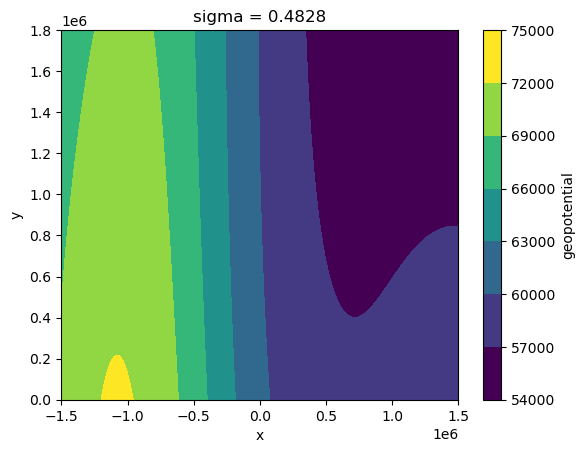

In [59]:
ds['geopotential'].isel(sigma=15).plot.contourf()

And so, let's interpolate to some common meteorological upper-air levels (750 hPa, 500 hPa, and 300 hPa) for plotting and analysis: 

In [61]:
grid = Grid(
    ds,
    coords={
        'X': {'center': 'x'},
        'Y': {'center': 'y'},
        'Z': {'center': 'sigma'}
    },
    periodic=False,
    autoparse_metadata=False
)

isobaric_levels = np.array([7.5e4, 5.0e4, 3.0e4]) 

geopotential_isobaric = grid.transform(
    ds['geopotential'],
    'Z',
    isobaric_levels,
    target_data=ds['pressure'],
    method='log'
)
temperature_isobaric = grid.transform(
    ds['temperature'],
    'Z',
    isobaric_levels,
    target_data=ds['pressure'],
    method='log'
)

ds_isobaric = xr.merge([geopotential_isobaric, temperature_isobaric])

ds_isobaric

<xarray.Dataset> Size: 2MB
Dimensions:       (y: 150, x: 250, pressure: 3)
Coordinates:
  * y             (y) float64 1kB 0.0 1.208e+04 2.416e+04 ... 1.788e+06 1.8e+06
  * x             (x) float64 2kB -1.5e+06 -1.488e+06 ... 1.488e+06 1.5e+06
  * pressure      (pressure) float64 24B 7.5e+04 5e+04 3e+04
Data variables:
    geopotential  (y, x, pressure) float64 900kB 2.529e+04 ... 9.459e+04
    temperature   (y, x, pressure) float64 900kB 291.3 262.7 ... 240.8 221.8

An additional benefit of now having our data in isobaric coordinates is that the form of kinematics and dynamics formulas are more straightforward compared to non-isobaric forms. To demonstrate this, let's plot the 300 hPa Temperature and Geostrophic Wind:

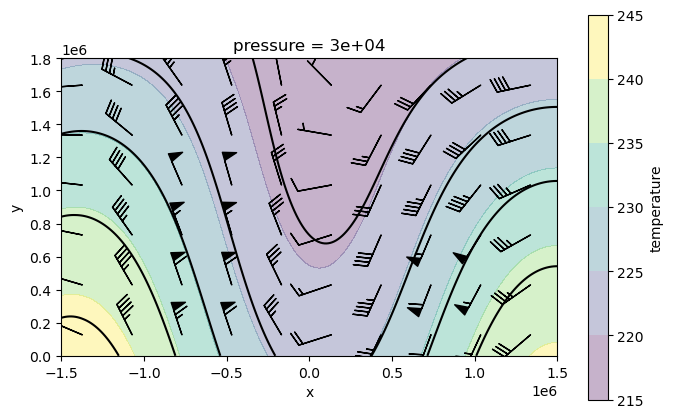

In [63]:
# Add inner coords for derivatives
ds_isobaric.coords['x_inner'] = (ds_isobaric['x'].values[:-1] + ds_isobaric['x'].values[1:]) / 2
ds_isobaric.coords['y_inner'] = (ds_isobaric['y'].values[:-1] + ds_isobaric['y'].values[1:]) / 2

# Create new grid
grid_isobaric = Grid(
    ds_isobaric,
    coords={
        'X': {'center': 'x', 'inner': 'x_inner'},
        'Y': {'center': 'y', 'inner': 'y_inner'},
        'Z': {'center': 'pressure'}
    },
    periodic=False,
    autoparse_metadata=False
)

# Calculate geostrophic wind components (without metrics)
f = 1.2e-4  # f-plane approximation of Coriolis force
u_wind = grid_isobaric.interp(
    -grid_isobaric.diff(ds_isobaric['geopotential'], 'Y', to='inner') / grid_isobaric.diff(ds_isobaric['y'], 'Y', to='inner') / f,
    to='inner',
    axis='X'
)
v_wind = grid_isobaric.interp(
    grid_isobaric.diff(ds_isobaric['geopotential'], 'X', to='inner') / grid_isobaric.diff(ds_isobaric['x'], 'X', to='inner') / f,
    to='inner',
    axis='Y'
)

# Plot
level = 3.0e4
fig, ax = plt.subplots(1, 1, figsize=[8,5])
ds_isobaric['temperature'].sel(pressure=level).plot.contourf(ax=ax, alpha=0.3)
ds_isobaric['geopotential'].sel(pressure=level).plot.contour(ax=ax, colors='k')
barb_reduce = slice(10, -10, 25)
ax.barbs(
    u_wind.x_inner.values[barb_reduce],
    u_wind.y_inner.values[barb_reduce],
    u_wind.sel(pressure=level).values[barb_reduce, barb_reduce],
    v_wind.sel(pressure=level).values[barb_reduce, barb_reduce]
)
ax.set_aspect('equal')

plt.show();

## Transforming onto a spatially-varying vertical coordinate

Next, we show how to transform onto a vertical coordinate that is spatially varying. To illustrate this feature, we use data from the Ocean Reanalysis [GLORYS](https://www.mercator-ocean.eu/en/ocean-science/glorys/), whose vertical coordinate is depth. We are interested in transforming the GLORYS data onto a ROMS grid , which has a terrain-following vertical coordinate, i.e., a vertical coordinate that is spatially varying.

In [19]:
import pooch

fname = pooch.retrieve(
    url="doi:10.6084/m9.figshare.27214182.v1/glorys_roms_data.nc",
    known_hash="md5:bc2382791cfb546b005b105359a26c85",
)
ds = xr.open_dataset(fname)
ds

<xarray.Dataset> Size: 9MB
Dimensions:              (time: 1, depth: 43, eta_rho: 102, xi_rho: 102,
                          s_rho: 20, s_w: 21)
Coordinates:
  * time                 (time) datetime64[ns] 8B 2012-08-10T12:00:00
  * depth                (depth) float32 172B 0.494 1.541 ... 2.866e+03
    lat_rho              (eta_rho, xi_rho) float64 83kB ...
    lon_rho              (eta_rho, xi_rho) float64 83kB ...
    layer_depth_rho      (eta_rho, xi_rho, s_rho) float32 832kB ...
    interface_depth_rho  (eta_rho, xi_rho, s_w) float32 874kB ...
Dimensions without coordinates: eta_rho, xi_rho, s_rho, s_w
Data variables:
    thetao               (time, depth, eta_rho, xi_rho) float64 4MB ...
    so                   (time, depth, eta_rho, xi_rho) float64 4MB ...
    bathymetry           (eta_rho, xi_rho) float64 83kB ...
    mask_rho             (eta_rho, xi_rho) int32 42kB ...
Attributes: (12/27)
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    references:                         http://www.mercator-ocean.fr
    ...                                 ...
    z_min:                              0.494025
    z_max:                              5727.917
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention
    NCO:                                netCDF Operators version 5.1.4 (Homep...
    history:                            Tue Aug  8 17:49:49 2023: ncks -A -v ...
    history_of_appended_files:          Tue Aug  8 17:49:49 2023: Appended fi...

The above dataset contains to vertical coordinates:

* `ds.depth`: describing 43 constant depth levels
* `ds.layer_depth_rho`: describing 20 terrain-following vertical layers (with dimension `s_rho`), where each vertical layer is spatially varying (depending on the horizontal `eta_rho`, `xi_rho` dimensions)

In [30]:
ds.depth  # depth coordinate

<xarray.DataArray 'depth' (depth: 43)> Size: 172B
array([4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00, 5.078224e+00,
       6.440614e+00, 7.929560e+00, 9.572997e+00, 1.140500e+01, 1.346714e+01,
       1.581007e+01, 1.849556e+01, 2.159882e+01, 2.521141e+01, 2.944473e+01,
       3.443415e+01, 4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02, 1.558507e+02,
       1.861256e+02, 2.224752e+02, 2.660403e+02, 3.181274e+02, 3.802130e+02,
       4.539377e+02, 5.410889e+02, 6.435668e+02, 7.633331e+02, 9.023393e+02,
       1.062440e+03, 1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03], dtype=float32)
Coordinates:
  * depth    (depth) float32 172B 0.494 1.541 2.646 ... 2.533e+03 2.866e+03

In [31]:
ds.layer_depth_rho  # terrain-following coordinate

<xarray.DataArray 'layer_depth_rho' (eta_rho: 102, xi_rho: 102, s_rho: 20)> Size: 832kB
[208080 values with dtype=float32]
Coordinates:
    lat_rho          (eta_rho, xi_rho) float64 83kB ...
    lon_rho          (eta_rho, xi_rho) float64 83kB ...
    layer_depth_rho  (eta_rho, xi_rho, s_rho) float32 832kB ...
Dimensions without coordinates: eta_rho, xi_rho, s_rho
Attributes:
    long_name:  Layer depth at rho-points
    units:      m

The following plot shows the depth of the 10th vertical layer in our terrain-following coordinate system. You can see that the depth of this layer varies from a few meters (near the Iceland and Greenland coasts) to more than 500 meters in locations away from the coasts.

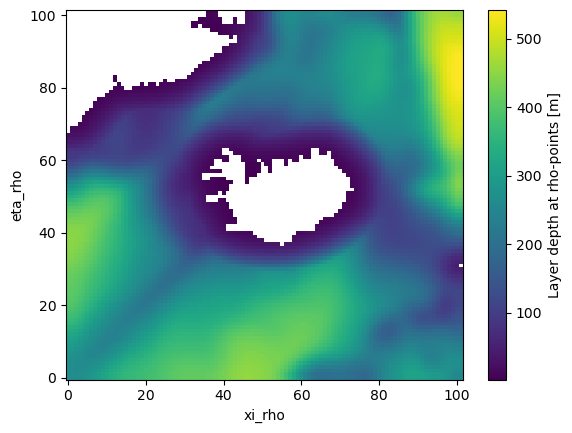

In [33]:
ds.layer_depth_rho.isel(s_rho=10).where(ds.mask_rho).plot()

The variables `thetao` and `so` in the dataset above are GLORYS temperature and salinity, and have already been regridded horizontally: from the GLORYS horizontal dimensions `latitude`, `longitude` to the ROMS horizontal dimensions `eta_rho`, `xi_rho`. We still have to perform the **vertical coordinate transformation**, though: from GLORYS constant `depth` levels to the ROMS terrain-following coordinate `layer_depth_rho`. Here is a temperature section along the `xi_rho` dimension.

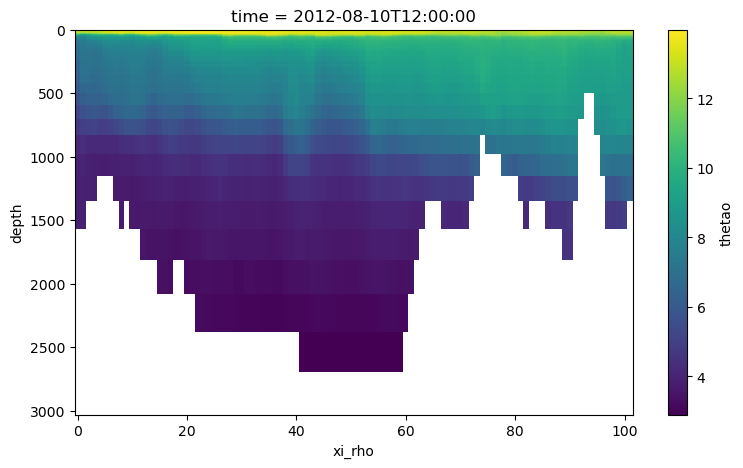

In [101]:
ds.thetao.isel(eta_rho=5).plot(yincrease=False, figsize=(9, 5))

We are now ready to perform the vertical coordinate transformation. We first create the `Grid` object as usual.

In [34]:
grid = Grid(ds, coords={'Z': {'center': 'depth'}}, periodic=False, autoparse_metadata=False)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary='fill'):
  * center   depth

Next, we transform the `thetao` data. Since our `target` has three dimensions, we need to specify the `target_dim` explicitly.

In [102]:
thetao_transformed = grid.transform(
    da=ds.thetao,  # the DataArray we want to transform
    axis='Z',  # the axis
    target=ds.layer_depth_rho,  # the new coordinate onto which we transform
    target_data=ds.depth,  # the original coordinate
    target_dim="s_rho"  # needs to be specified because target has more than one dimension
)

The transformed `thetao` data has the desired dimensions and coordinates.

In [103]:
thetao_transformed

<xarray.DataArray 'thetao' (time: 1, eta_rho: 102, xi_rho: 102, s_rho: 20)> Size: 2MB
array([[[[        nan,         nan,  3.99415499, ..., 11.3094888 ,
          13.01453999, 13.10635127],
         [ 3.91078881,  3.92256902,  3.98801882, ..., 11.05355676,
          13.01802339, 13.12892354],
         [ 3.84163734,  3.88343985,  3.92194366, ..., 11.38148922,
          13.10431851, 13.22149976],
         ...,
         [        nan,         nan,         nan, ..., 12.47706319,
          12.94017807, 13.20547228],
         [        nan,         nan,         nan, ..., 12.69868191,
          13.184553  , 13.4133628 ],
         [        nan,         nan,         nan, ..., 12.83855174,
          13.30533248, 13.52362899]],

        [[        nan,         nan,  3.9556798 , ..., 11.44653346,
          13.05692947, 13.1391515 ],
         [ 3.88633259,  3.89434962,  3.91574928, ..., 10.98825553,
          13.01525268, 13.14992928],
         [ 3.76430432,  3.77818737,  3.80344718, ..., 11.44149368,
          13.10590207, 13.21198149],
...
         [-0.95747527, -0.94747118, -0.92997137, ...,  8.03948367,
           9.13365521,  9.2120947 ],
         [        nan, -0.93420389, -0.91041249, ...,  8.40402702,
           9.30006631,  9.34442788],
         [        nan, -0.92544874, -0.89845123, ...,  8.5779045 ,
           9.41584494,  9.5142805 ]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,  7.52233225,
           8.71015546,  8.77361555],
         [        nan,         nan, -0.91099053, ...,  8.17675209,
           9.12436744,  9.17878799],
         [        nan,         nan, -0.90872098, ...,  8.63630804,
           9.37979198,  9.41567871]]]])
Coordinates:
  * time             (time) datetime64[ns] 8B 2012-08-10T12:00:00
    lat_rho          (eta_rho, xi_rho) float64 83kB 58.57 58.59 ... 70.11 70.08
    lon_rho          (eta_rho, xi_rho) float64 83kB 328.7 328.9 ... 357.1 357.5
    layer_depth_rho  (eta_rho, xi_rho, s_rho) float32 832kB ...
Dimensions without coordinates: eta_rho, xi_rho, s_rho

If we plot the same section as before, we can see that the transformed temperature follows the terrain-following coordinate.

In [104]:
def section_plot_along_xi(field, eta=5, show_interfaces=False):

    fig, ax = plt.subplots(1, 1, figsize=(9, 5))

    xdim = "xi_rho"
    depth_label = "layer_depth_rho"

    kwargs = {"x": xdim, "y": depth_label, "yincrease": False}
    field.isel(eta_rho=eta).plot(**kwargs, ax=ax)

    if show_interfaces:
        for i in range(len(ds.s_rho)):
            ax.plot(
                ds.interface_depth_rho.isel(eta_rho=eta)[xdim], ds.interface_depth_rho.isel({"eta_rho": eta, "s_w": i}), color="k"
            )
    ax.set_title("Transformed field with terrain-following coordinate")

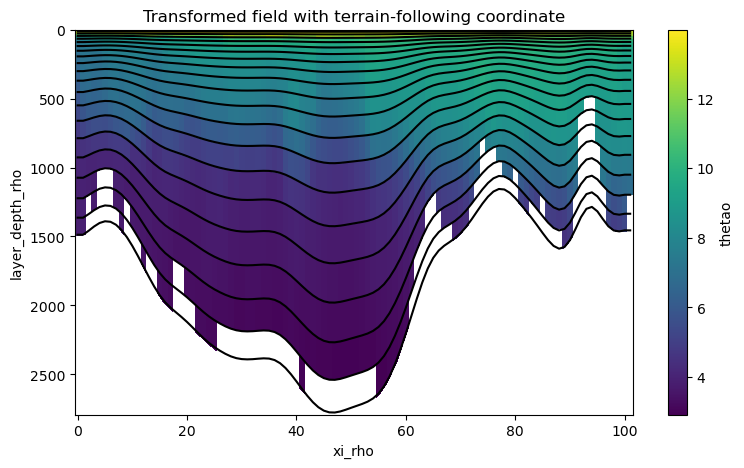

In [105]:
section_plot_along_xi(thetao_transformed, show_interfaces=True)

Since the GLORYS topography is quite a bit rougher than that of our ROMS grid, there are some missing values (NaNs) in the lowermost layers at the places where the GLORYS topography differs from the ROMS grid topography. This is not a problem with `xgcm.transform()` but due to a mismatch of our original and target data. This problem could for example be fixed by extrapolating temperature in the horizontal and / or vertical directions before doing the vertical coodinate transformation.

## Performance
By default xgcm performs some simple checks when using `method='linear'`. 
It checks if the last value of the data is larger than the first, and if not, the data is flipped.This ensures that monotonically decreasing variables, like temperature are interpolated correctly. These checks have a performance penalty (~30% in some preliminary tests).

If you have manually flipped your data and ensured that its monotonically increasing, you can switch the checks off to get even better performance.
```python
grid.transform(..., method='linear', bypass_checks=True)
```